In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset #dataloader to breakout datasets into mini batches
import glob #pattern matching #travel in directry
import matplotlib.pyplot as plt #for plotting
from sklearn.metrics import confusion_matrix, accuracy_score #to evaluate the perfomance #classiification
import random
import cv2
import sys

In [ ]:
tumor = []
for f in glob.iglob("/content/drive/MyDrive/Dataset/brain tumor/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img) #separeting channels
    img = cv2.merge([r,g,b])
    tumor.append(img)

healthy = []
for f in glob.iglob("/content/drive/MyDrive/Dataset/brain tumor/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(10, 5, replace=False)

array([7, 8, 3, 0, 4])

In [ ]:
#visualizing

def plot_random(healthy, tumor, num=5):
    # Ensure healthy and tumor are numpy arrays
    healthy = np.array(healthy)
    tumor = np.array(tumor)

    # Randomly sample images from each category
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    # Plot healthy images
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy')
        plt.imshow(healthy_imgs[i])
        plt.axis('off')
    plt.show()

    # Plot tumor images
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Tumor')
        plt.imshow(tumor_imgs[i])
        plt.axis('off')
    plt.show()


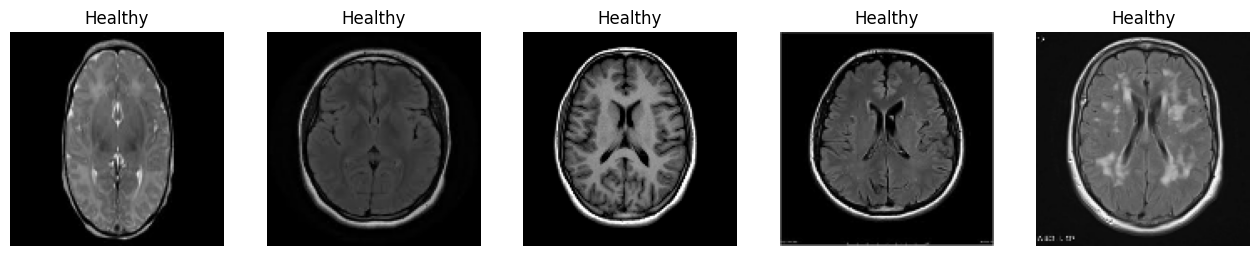

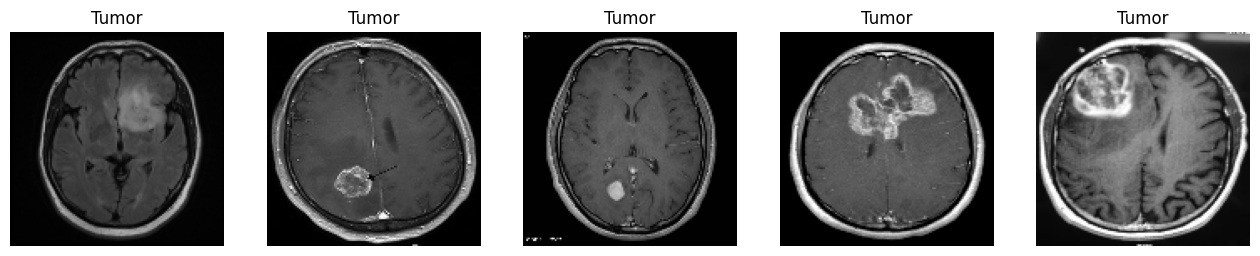

In [ ]:
plot_random(healthy, tumor, num=5)

In [ ]:
#Dataset class

class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [ ]:
#Dataset class

class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []

        for f in glob.iglob("/content/drive/MyDrive/Dataset/brain tumor/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/Dataset/brain tumor/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        #images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        #labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        #Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()

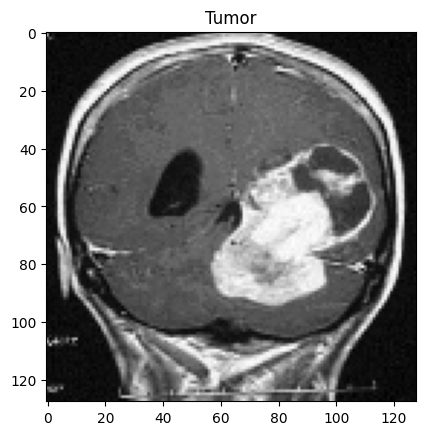

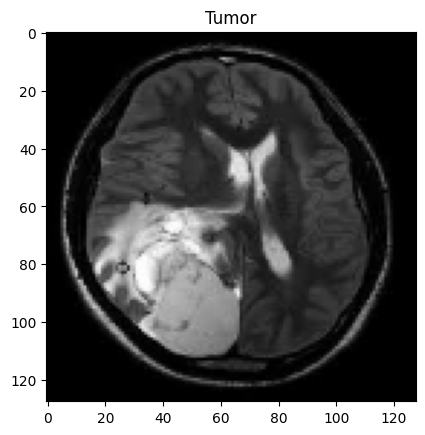

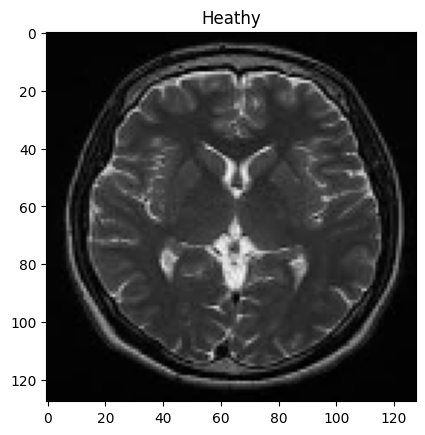

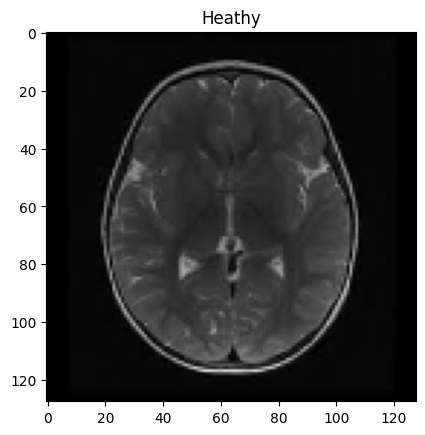

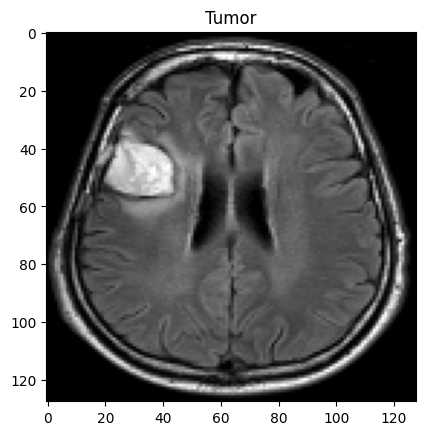

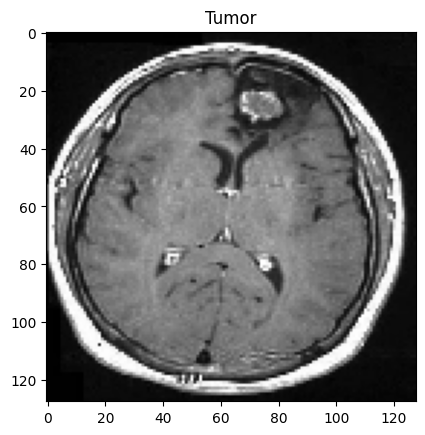

In [ ]:
#Dataloader

names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [ ]:
#Model

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


In [ ]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.8841, 0.4843, 0.1916, 0.6726, 0.6006, 0.8500, 0.7049, 0.2432, 0.8691,
        0.7178], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.8841, 0.4843, 0.1916, 0.6726, 0.6006, 0.8500, 0.7049, 0.2432, 0.8691,
        0.7178], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.7817, 0.2346, 0.0367, 0.4523, 0.3607, 0.7225, 0.4970, 0.0592, 0.7554,
        0.5152], device='cuda:0')


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


mri_dataset = MRI()
mri_dataset.normalize()
model = CNN().to(device)


In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
error = nn.BCELoss()


In [ ]:
for epoch in range(1, EPOCH + 1):
    losses = []
    for D in dataloader:
        # Transfer data to GPU
        data = D['image'].to(device)
        label = D['label'].to(device)

        # Forward pass
        y_hat = model(data)

        # Calculate loss and perform backpropagation
        loss = error(y_hat.squeeze(), label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss
        losses.append(loss.item())

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Train Epoch: {epoch} \t Loss: {np.mean(losses):.6f}')


Train Epoch: 10 	 Loss: 0.688772
Train Epoch: 20 	 Loss: 0.674637
Train Epoch: 30 	 Loss: 0.644411
Train Epoch: 40 	 Loss: 0.598613
Train Epoch: 50 	 Loss: 0.565873
Train Epoch: 60 	 Loss: 0.548323
Train Epoch: 70 	 Loss: 0.535715
Train Epoch: 80 	 Loss: 0.524554
Train Epoch: 90 	 Loss: 0.513684
Train Epoch: 100 	 Loss: 0.502536
Train Epoch: 110 	 Loss: 0.490856
Train Epoch: 120 	 Loss: 0.478548
Train Epoch: 130 	 Loss: 0.465563
Train Epoch: 140 	 Loss: 0.451890
Train Epoch: 150 	 Loss: 0.437587
Train Epoch: 160 	 Loss: 0.422791
Train Epoch: 170 	 Loss: 0.407694
Train Epoch: 180 	 Loss: 0.392497
Train Epoch: 190 	 Loss: 0.377365
Train Epoch: 200 	 Loss: 0.362404
Train Epoch: 210 	 Loss: 0.347657
Train Epoch: 220 	 Loss: 0.333117
Train Epoch: 230 	 Loss: 0.318753
Train Epoch: 240 	 Loss: 0.304531
Train Epoch: 250 	 Loss: 0.290446
Train Epoch: 260 	 Loss: 0.276530
Train Epoch: 270 	 Loss: 0.262849
Train Epoch: 280 	 Loss: 0.249451
Train Epoch: 290 	 Loss: 0.236326
Train Epoch: 300 	 Loss

In [ ]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        #predictions
        y_hat = model(image)

        # Save predictions and true labels
        outputs.append(y_hat.cpu().numpy())
        y_true.append(label.cpu().numpy())

# Concatenate all predictions and labels
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)


Model Accuracy: 0.9708


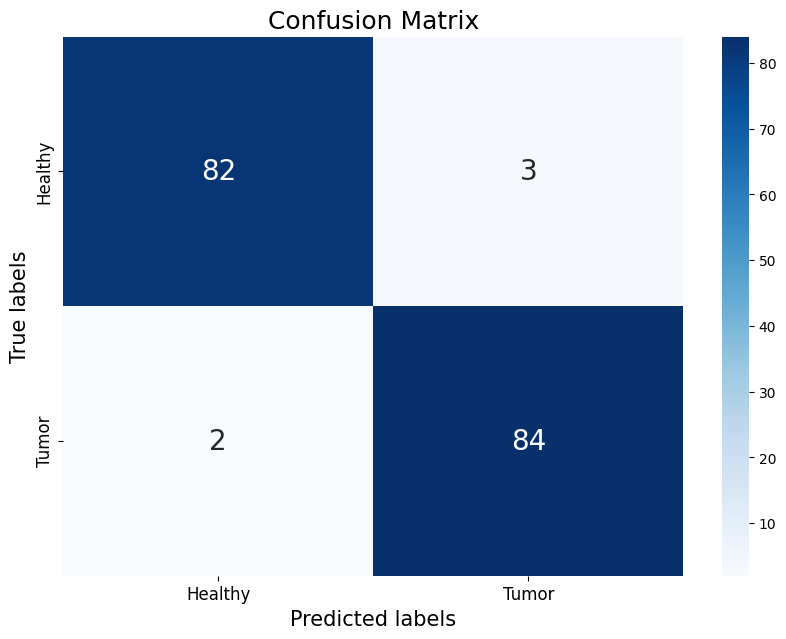

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Define threshold function
def threshold(outputs, threshold=0.5):
    return (outputs >= threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_true, threshold(outputs))
print(f"Model Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax, annot_kws={"size": 20})

# Add labels and title
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=18)
ax.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=12)
ax.yaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=12)
plt.show()


In [ ]:
print(accuracy_score(y_true, (outputs >= 0.5).astype(int)))


0.9707602339181286


In [ ]:
# Save
torch.save(model.state_dict(), 'model.pth')


In [ ]:
from google.colab import files

# Download the model file
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>